# Pre-processing of GLAMOS MB data:

Does the pre-processing of the point MB measurements from GLAMOS (winter and summer).

# Point Mass Balance data:

## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from cmcrameri import cm
from calendar import monthrange

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_CH import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

## Transform .dat files to .csv:

Transform the seasonal and winter PMB .dat files to .csv for simplicity. 

In [3]:
process_pmb_dat_files()

##  Assemble measurement periods:
### Annual measurements: 
Process annual measurements and put all stakes into one csv file

In [4]:
# Display the first two rows
df_annual_raw = process_annual_stake_data(path_PMB_GLAMOS_csv_a)
df_annual_raw.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,mb_raw,density,density_quality,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,2003,01,oberaar,20021006,20031011,46.538806,8.233237,2389.812633,-6174,annual,...,-686,900,1,1,1,102,45,92,0,hm
1,2003,02,oberaar,20021006,20031011,46.536611,8.225514,2499.825727,-5310,annual,...,-590,900,1,1,1,91,45,79,0,hm


### Winter measurements:
For each point in annual meas., take winter meas that was taken closest:

In [5]:
process_winter_stake_data(df_annual_raw, path_PMB_GLAMOS_csv_w,
                          path_PMB_GLAMOS_csv_w_clean)

### Assemble both periods:

In [6]:
df_all_raw = assemble_all_stake_data(df_annual_raw,
                                     path_PMB_GLAMOS_csv_w_clean,
                                     path_PMB_GLAMOS_csv)

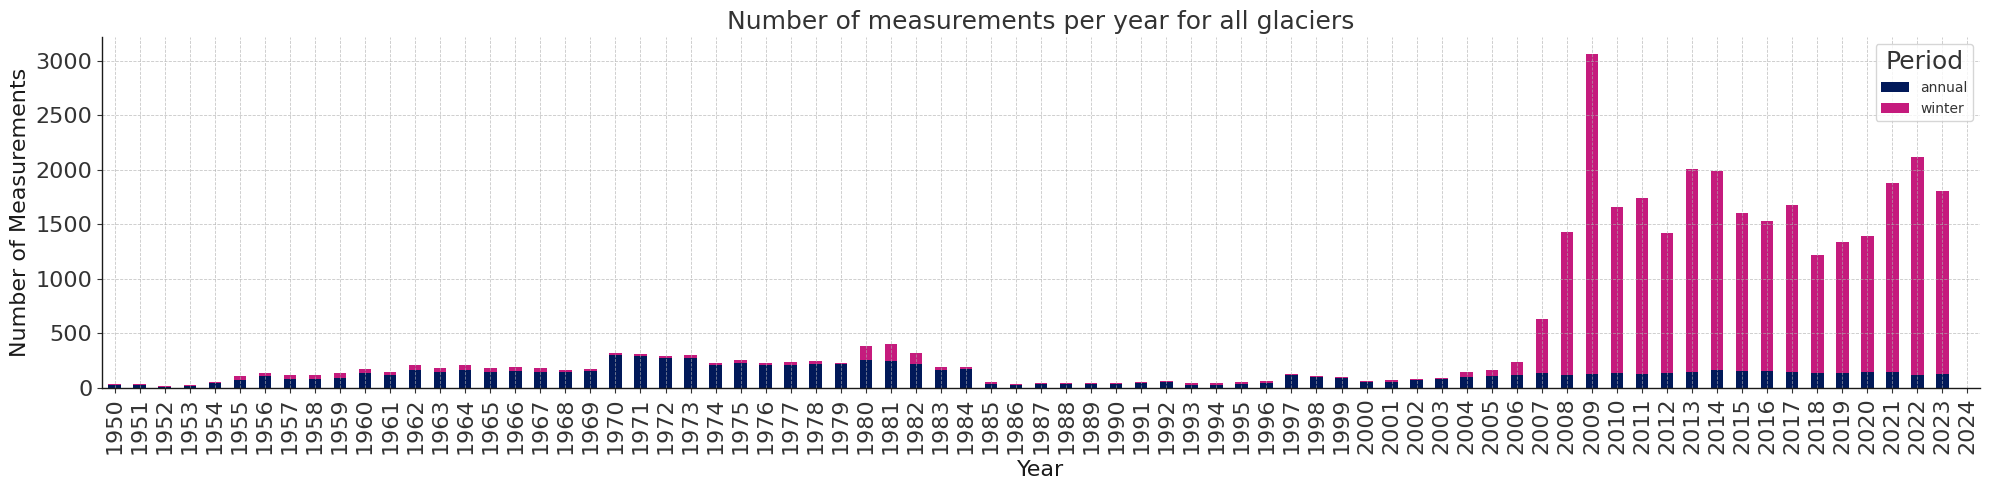

In [7]:
# Plot: Number of measurements per year
df_measurements_per_year = df_all_raw.groupby(['YEAR',
                                               'PERIOD']).size().unstack()
df_measurements_per_year.plot(kind='bar',
                              stacked=True,
                              figsize=(20, 5),
                              color=[color_1, color_2])
plt.title('Number of measurements per year for all glaciers')
plt.ylabel('Number of Measurements')
plt.xlabel('Year')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

## Add RGIs Ids:

For each PMB measurement, we want to add the RGI ID (v6) of the shapefile it belongs to. 

In [8]:
glacier_outline_fname = '../../../data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'
df_pmb = add_rgi_ids_to_df(df_all_raw, glacier_outline_fname)

rgiids6 = df_pmb[['GLACIER', 'RGIId']].drop_duplicates()
if check_multiple_rgi_ids(rgiids6):
    print(
        "-- Alert: The following glaciers have more than one RGIId. Cleaning up."
    )
    df_pmb_clean = clean_rgi_ids(df_pmb.copy())
    df_pmb_clean.reset_index(drop=True, inplace=True)

    rgiids6_clean = df_pmb_clean[['GLACIER', 'RGIId']].drop_duplicates()
    if check_multiple_rgi_ids(rgiids6_clean):
        print("-- Error: Some glaciers still have more than one RGIId.")
    else:
        print("-- All glaciers are correctly associated with a single RGIId.")
else:
    print("-- All glaciers are correctly associated with a single RGIId.")
    df_pmb_clean = df_pmb

Finding closest RGIId:   0%|          | 0/2620 [00:00<?, ?it/s]

-- Alert: The following glaciers have more than one RGIId. Cleaning up.
-- All glaciers are correctly associated with a single RGIId.


## Cut from 1951:

Number of winter and annual samples: 36453
Number of annual samples: 8985
Number of winter samples: 27468


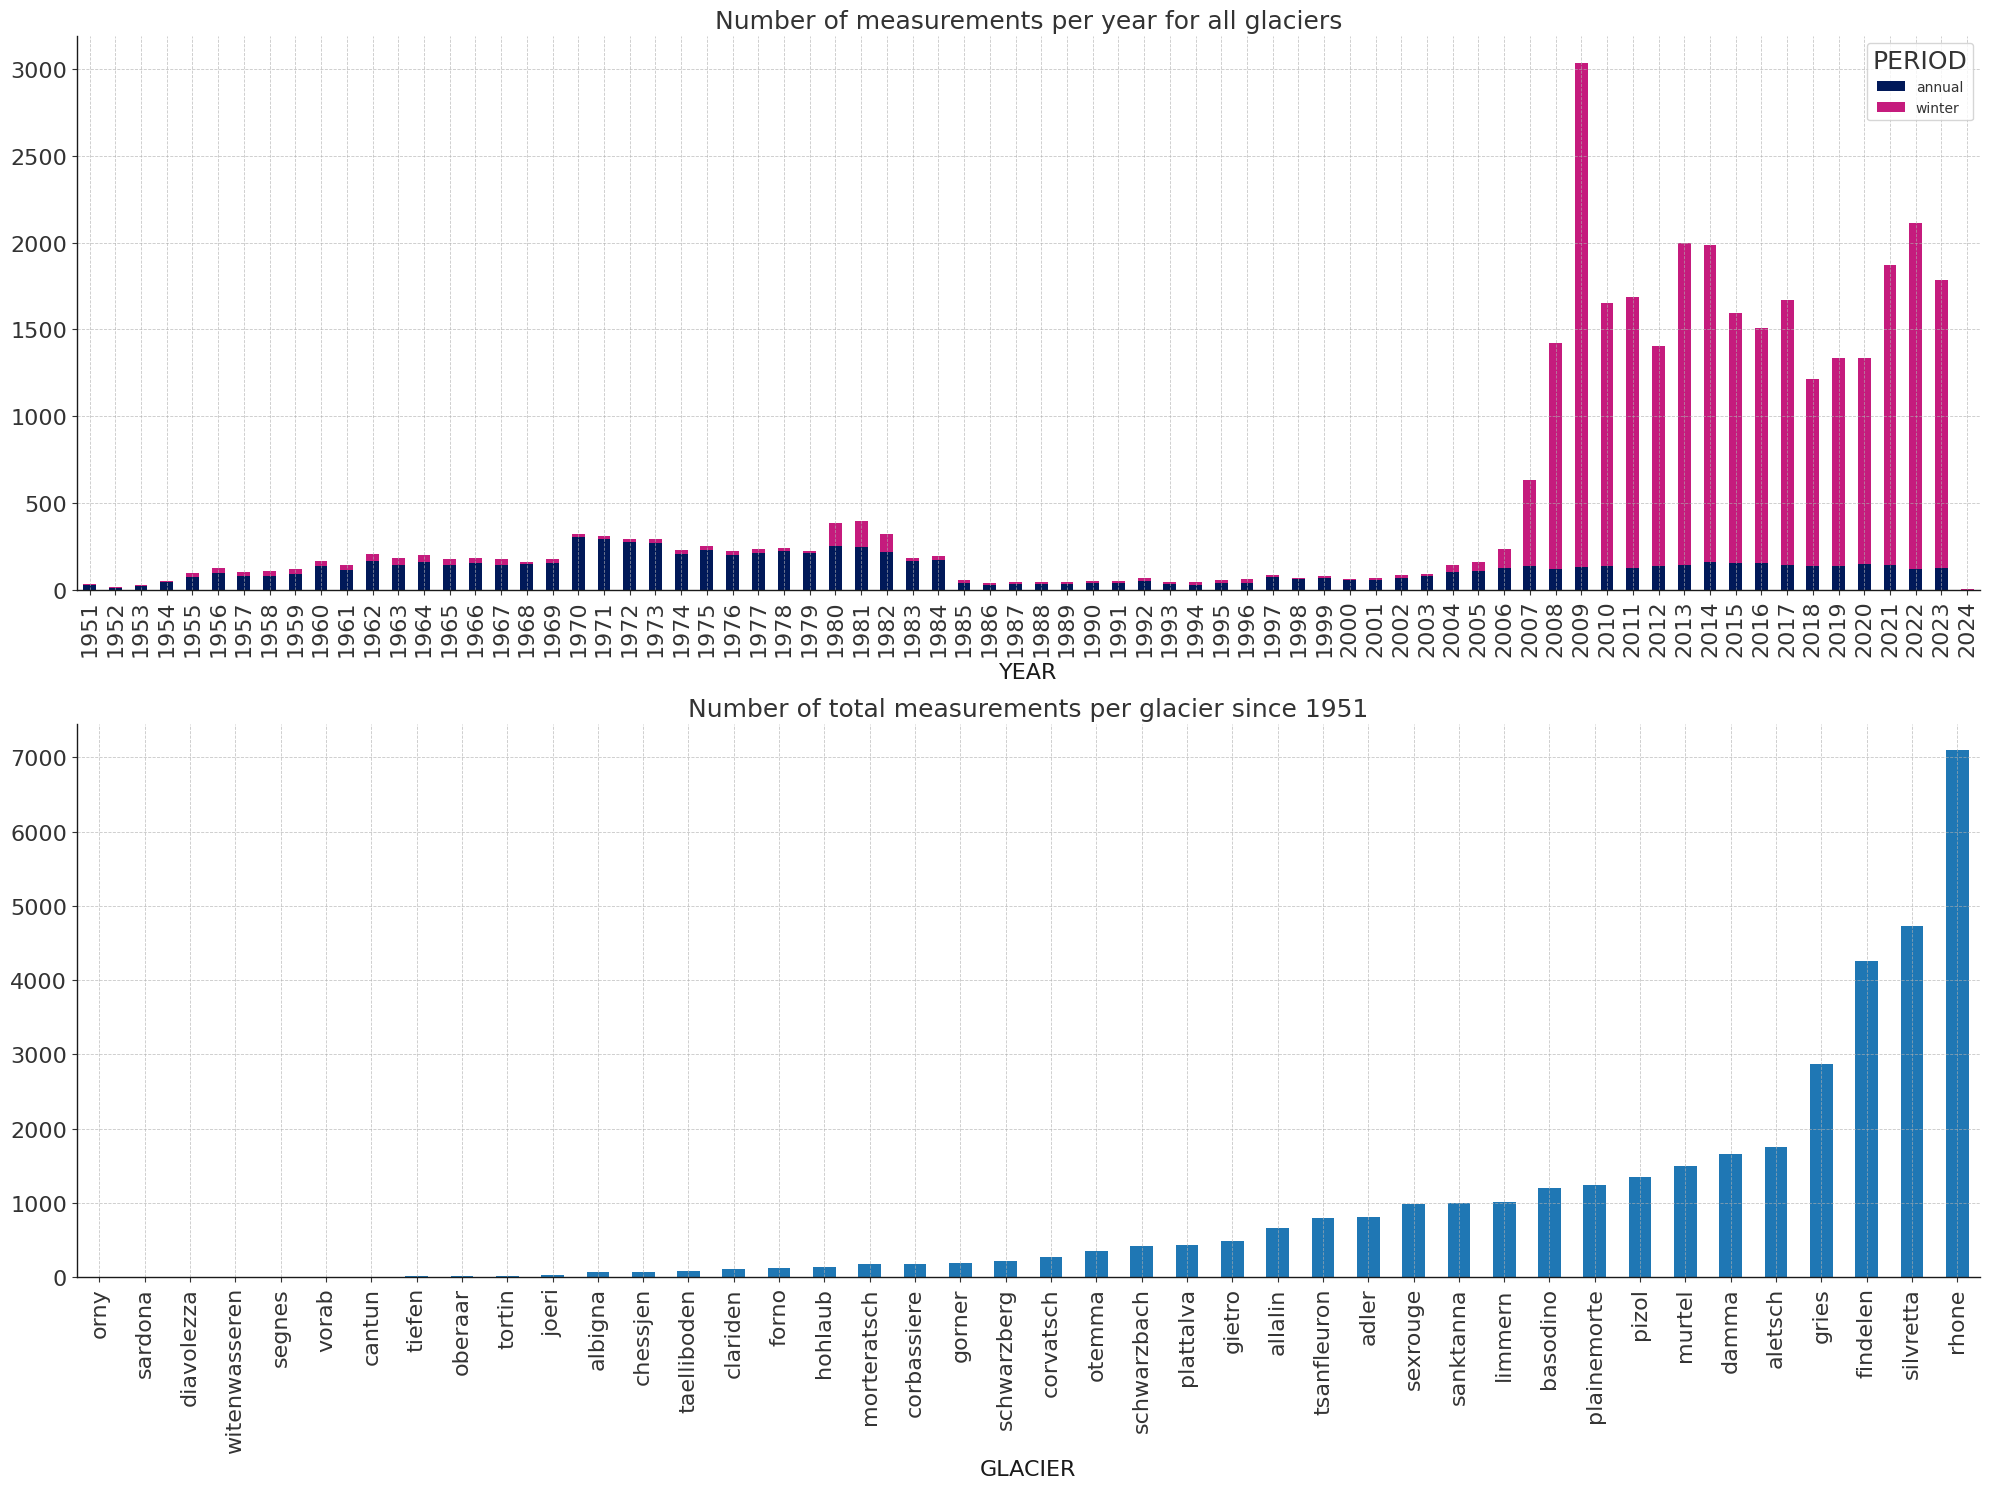

In [9]:
# Filter to start of MS data (1951) or ERA5-Land data (1950):
df_pmb_50s = df_pmb_clean[df_pmb_clean.YEAR > 1950].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])

# Change from mm w.e. to m w.e.
df_pmb_50s['POINT_BALANCE'] = df_pmb_50s['POINT_BALANCE'] / 1000

# merge ClaridenL and ClaridenU into one glacier:
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenU', 'GLACIER'] = 'clariden'
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenL', 'GLACIER'] = 'clariden'

print('Number of winter and annual samples:', len(df_pmb_50s))
print('Number of annual samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'winter']))

# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s.groupby(['YEAR',
                    'PERIOD']).size().unstack().plot(kind='bar',
                                                     stacked=True,
                                                     color=[color_1, color_2],
                                                     ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

### Merge stakes that are close: 
Especially with winter probes, a lot of measurements were done at the same place in the raw data and this leads to noise. We merge the stakes that are very close and keep the mean of the measurement.


In [10]:
df_pmb_50s_clean = pd.DataFrame()
for gl in tqdm(df_pmb_50s.GLACIER.unique(), desc='Merging stakes'):
    print(f'-- {gl.capitalize()}:')
    df_gl = df_pmb_50s[df_pmb_50s.GLACIER == gl]
    df_gl_cleaned = remove_close_points(df_gl)
    df_pmb_50s_clean = pd.concat([df_pmb_50s_clean, df_gl_cleaned])

df_pmb_50s_clean.drop(['x', 'y'], axis=1, inplace=True)

# Save intermediate output
print('Saving intermediate output df_pmb_50s.csv to {path_PMB_GLAMOS_csv}')
df_pmb_50s_clean.to_csv(os.path.join(path_PMB_GLAMOS_csv, 'df_pmb_50s.csv'),
                        index=False)
df_pmb_50s_clean[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
                  'PERIOD']].to_csv(os.path.join(path_PMB_GLAMOS_csv,
                                                 'coordinate_50s.csv'),
                                    index=False)

Merging stakes:   0%|          | 0/42 [00:00<?, ?it/s]

-- Adler:


2025-04-09 13:45:08,314 - INFO - --- Number of points dropped: 5
2025-04-09 13:45:08,730 - INFO - --- Number of points dropped: 1


-- Albigna:
-- Aletsch:


2025-04-09 13:45:12,238 - INFO - --- Number of points dropped: 233


-- Allalin:


2025-04-09 13:45:15,713 - INFO - --- Number of points dropped: 68


-- Basodino:


2025-04-09 13:45:17,889 - INFO - --- Number of points dropped: 6
2025-04-09 13:45:17,899 - INFO - --- Number of points dropped: 0


-- Cantun:
-- Chessjen:


2025-04-09 13:45:18,596 - INFO - --- Number of points dropped: 15
2025-04-09 13:45:19,271 - INFO - --- Number of points dropped: 0


-- Clariden:
-- Corbassiere:


2025-04-09 13:45:20,214 - INFO - --- Number of points dropped: 1


-- Corvatsch:


2025-04-09 13:45:20,799 - INFO - --- Number of points dropped: 0
2025-04-09 13:45:21,002 - INFO - --- Number of points dropped: 200


-- Damma:


2025-04-09 13:45:21,010 - INFO - --- Number of points dropped: 0


-- Diavolezza:
-- Findelen:


2025-04-09 13:45:22,206 - INFO - --- Number of points dropped: 59
2025-04-09 13:45:22,618 - INFO - --- Number of points dropped: 0


-- Forno:
-- Gietro:


2025-04-09 13:45:24,595 - INFO - --- Number of points dropped: 0
2025-04-09 13:45:24,874 - INFO - --- Number of points dropped: 4


-- Gorner:
-- Gries:


2025-04-09 13:45:28,188 - INFO - --- Number of points dropped: 39


-- Hohlaub:


2025-04-09 13:45:29,741 - INFO - --- Number of points dropped: 2
2025-04-09 13:45:30,127 - INFO - --- Number of points dropped: 0


-- Joeri:
-- Limmern:


2025-04-09 13:45:31,976 - INFO - --- Number of points dropped: 16
2025-04-09 13:45:32,681 - INFO - --- Number of points dropped: 0


-- Morteratsch:
-- Murtel:


2025-04-09 13:45:33,410 - INFO - --- Number of points dropped: 29
2025-04-09 13:45:33,528 - INFO - --- Number of points dropped: 0
2025-04-09 13:45:33,534 - INFO - --- Number of points dropped: 0


-- Oberaar:
-- Orny:
-- Otemma:


2025-04-09 13:45:33,779 - INFO - --- Number of points dropped: 1


-- Pizol:


2025-04-09 13:45:34,879 - INFO - --- Number of points dropped: 121


-- Plainemorte:


2025-04-09 13:45:35,804 - INFO - --- Number of points dropped: 11


-- Plattalva:


2025-04-09 13:45:37,693 - INFO - --- Number of points dropped: 8


-- Rhone:


2025-04-09 13:45:39,152 - INFO - --- Number of points dropped: 221


-- Sanktanna:


2025-04-09 13:45:39,983 - INFO - --- Number of points dropped: 27
2025-04-09 13:45:39,991 - INFO - --- Number of points dropped: 0


-- Sardona:
-- Schwarzbach:


2025-04-09 13:45:40,552 - INFO - --- Number of points dropped: 44


-- Schwarzberg:


2025-04-09 13:45:42,211 - INFO - --- Number of points dropped: 3
2025-04-09 13:45:42,324 - INFO - --- Number of points dropped: 0


-- Segnes:
-- Sexrouge:


2025-04-09 13:45:43,119 - INFO - --- Number of points dropped: 17


-- Silvretta:


2025-04-09 13:45:46,004 - INFO - --- Number of points dropped: 34


-- Taelliboden:


2025-04-09 13:45:47,301 - INFO - --- Number of points dropped: 0
2025-04-09 13:45:47,448 - INFO - --- Number of points dropped: 0
2025-04-09 13:45:47,698 - INFO - --- Number of points dropped: 0


-- Tiefen:
-- Tortin:
-- Tsanfleuron:


2025-04-09 13:45:48,296 - INFO - --- Number of points dropped: 18
2025-04-09 13:45:48,409 - INFO - --- Number of points dropped: 0
2025-04-09 13:45:48,451 - INFO - --- Number of points dropped: 0


-- Vorab:
-- Witenwasseren:
Saving intermediate output df_pmb_50s.csv to {path_PMB_GLAMOS_csv}


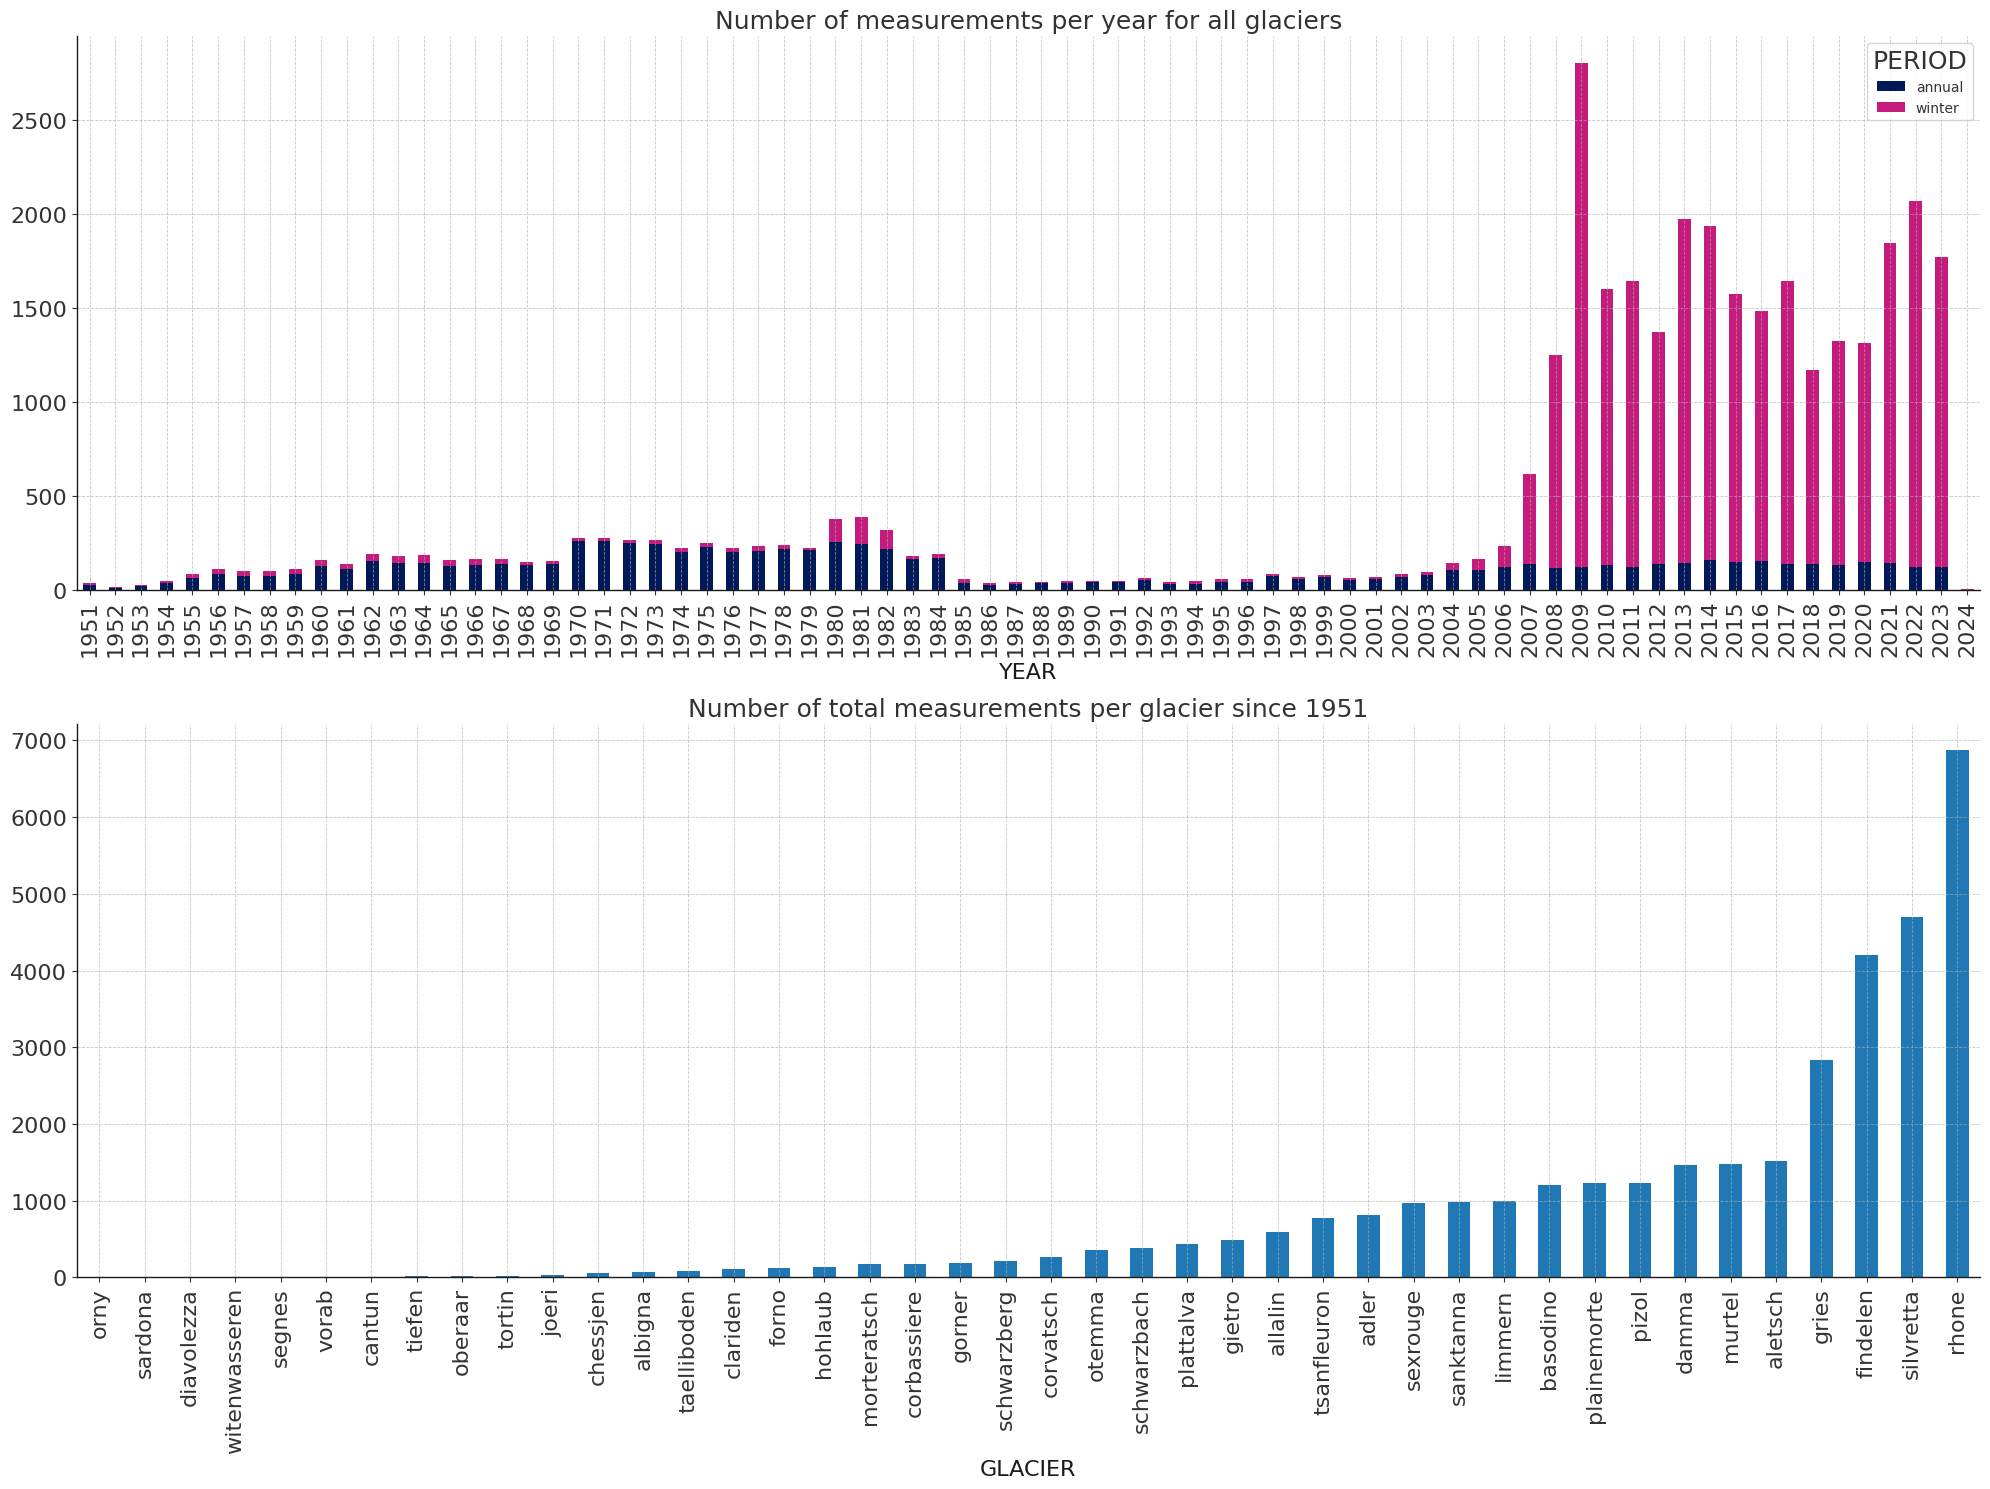

In [11]:
# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s_clean.groupby(['YEAR', 'PERIOD'
                          ]).size().unstack().plot(kind='bar',
                                                   stacked=True,
                                                   color=[color_1, color_2],
                                                   ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s_clean.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

In [12]:
glacier_list = list(df_pmb_50s_clean.GLACIER.unique())
print('Number of glaciers:', len(glacier_list))
glacier_list.sort()
glacier_list

Number of glaciers: 42


['adler',
 'albigna',
 'aletsch',
 'allalin',
 'basodino',
 'cantun',
 'chessjen',
 'clariden',
 'corbassiere',
 'corvatsch',
 'damma',
 'diavolezza',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'orny',
 'otemma',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'sanktanna',
 'sardona',
 'schwarzbach',
 'schwarzberg',
 'segnes',
 'sexrouge',
 'silvretta',
 'taelliboden',
 'tiefen',
 'tortin',
 'tsanfleuron',
 'vorab',
 'witenwasseren']

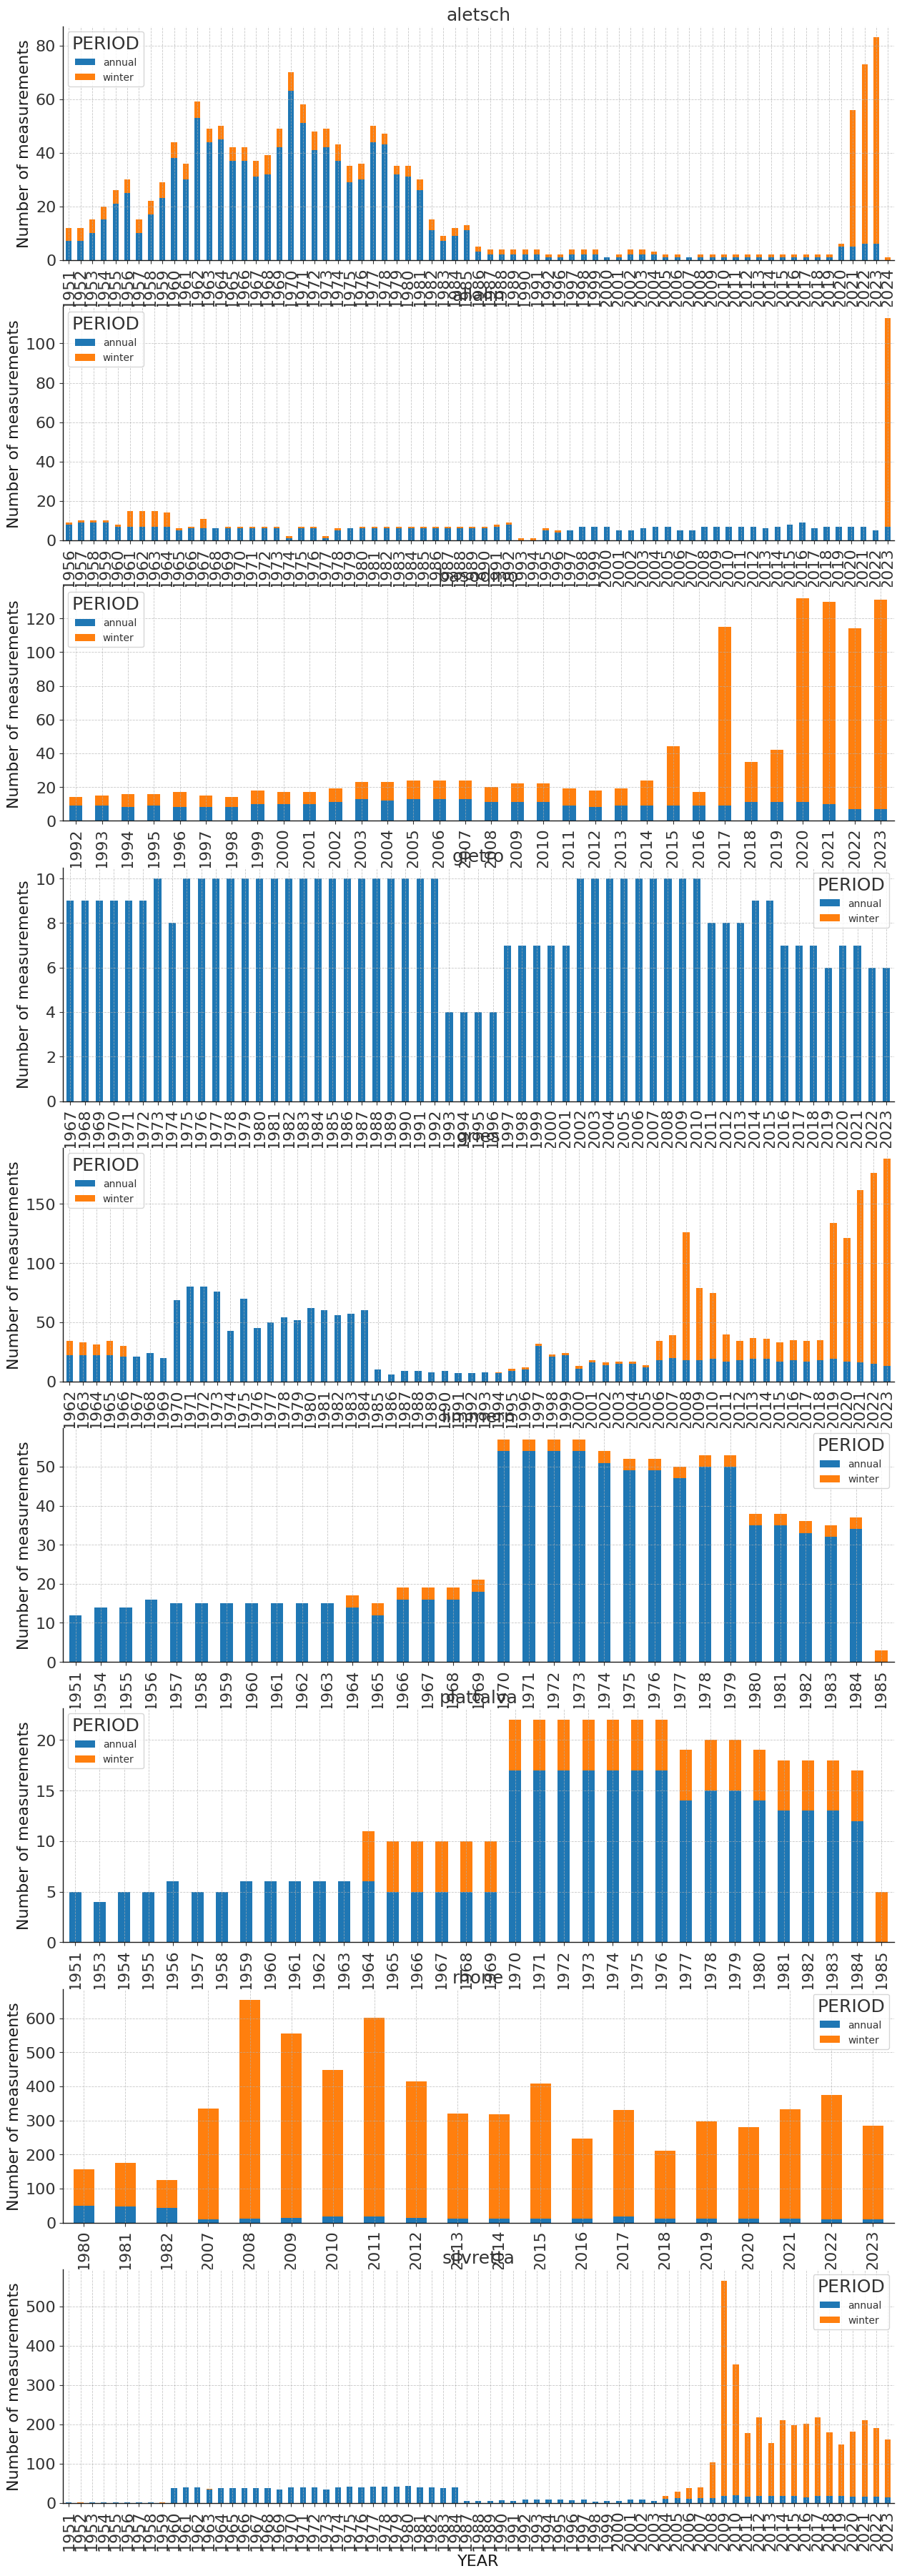

In [13]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_50s_clean.groupby(['GLACIER', 'YEAR', 'PERIOD'
                                      ]).size().unstack().reset_index()

num_gl_annual = df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual'].groupby(
    ['GLACIER']).size().sort_values()

# Plot one glacier per column:
big_gl = num_gl_annual[num_gl_annual > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                            kind='bar',
                                            stacked=True,
                                            ax=ax[i],
                                            title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title

In [14]:
print('Number of winter and annual samples:', len(df_pmb_50s_clean))
print('Number of annual samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'winter']))

Number of winter and annual samples: 35270
Number of annual samples: 8636
Number of winter samples: 26634


## Add topographical information from OGGM:

In [16]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir='../../../data/OGGM/',
    rgi_region="11",
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)

export_oggm_grids(df_pmb_50s_clean, gdirs, output_path=path_OGGM_xrgrids)

df_pmb_topo = merge_pmb_with_oggm_data(df_pmb=df_pmb_50s_clean,
                                       gdirs=gdirs,
                                       rgi_region="11",
                                       rgi_version="6")

2025-04-09 13:49:21: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-09 13:49:21: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-09 13:49:21: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-09 13:49:21: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-04-09 13:49:21: oggm.cfg: Multiprocessing switched ON after user settings.
2025-04-09 13:49:21: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-04-09 13:49:22: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-04-09 13:49:22: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2025-04-09 13:49:38: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
# Example:
glacierName = 'aletsch'
# stakes
df_stakes = df_pmb_topo.copy()
df_stakes = df_stakes[(df_stakes['GLACIER'] == glacierName)]
RGIId = df_stakes.RGIId.unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'../../../data/OGGM/xr_grids/{RGIId}.nc')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes["POINT_LON"].values, df_stakes["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes['x'] = x_stake
df_stakes['y'] = y_stake

# plot stakes
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ds_oggm.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='x',
                y='y',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier OGGM')

ax = plt.subplot(122)
path_SGI_topo = '../../../data/GLAMOS/topo/SGI2020/'
sgi_grid = xr.open_dataset(path_SGI_topo +
                           f'xr_masked_grids/{glacierName}.zarr')
sgi_grid.glacier_mask.plot(cmap='binary', ax=ax)
sns.scatterplot(df_stakes,
                x='POINT_LON',
                y='POINT_LAT',
                hue='within_glacier_shape',
                ax=ax,
                palette=['r', 'b'])
ax.set_title('Stakes on glacier')

In [ ]:
# Save to CSV
fname = 'CH_wgms_dataset_all.csv'
# Drop points that are not within the glacier shape
df_pmb_topo = df_pmb_topo[df_pmb_topo['within_glacier_shape']]
df_pmb_topo = df_pmb_topo.drop(columns=['within_glacier_shape'])
df_pmb_topo.to_csv(os.path.join(path_PMB_GLAMOS_csv, fname), index=False)

In [ ]:
# Count and display the number of samples
print(f"Total number of winter and annual samples: {len(df_pmb_topo)}")

# Count occurrences of 'PERIOD' values
period_counts = df_pmb_topo['PERIOD'].value_counts()
print(f"Number of annual samples: {period_counts.get('annual', 0)}")
print(f"Number of winter samples: {period_counts.get('winter', 0)}")

# Unique years, sorted
unique_years = np.sort(df_pmb_topo.YEAR.unique())
print(f"Unique years: {unique_years}")

# Unique glaciers, sorted
glacier_list = sorted(df_pmb_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

## Give new stake IDs:
Give new stake IDs with glacier name and then a number according to the elevation. This is because accross glaciers some stakes have the same ID which is not practical.

In [ ]:
df_pmb_topo = rename_stakes_by_elevation(df_pmb_topo)

# Check the condition
check_point_ids_contain_glacier(df_pmb_topo)
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))

# Save to csv:
df_pmb_topo.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
                   index=False)

# Histogram of mass balance
df_pmb_topo['POINT_BALANCE'].hist(bins=20)
plt.xlabel('Mass balance [m w.e.]')

# Glacier wide MB:

## Obs: no fixed dates, but using observed periods.

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'obs' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])

# Transform all files to csv
emptyfolder(path_SMB_GLAMOS_csv + 'obs/')
for file in glamosfiles_smb:
    fileName = re.split('.dat', file)[0]
    processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                        path_SMB_GLAMOS_csv + 'obs/')

# Example:
fileName = 'aletsch_obs.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'obs/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

## Fix: with fixed periods (hydrological year).

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'fix' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])
# Transform all files to csv
emptyfolder(path_SMB_GLAMOS_csv + 'fix/')
for file in glamosfiles_smb:
    fileName = re.split('.dat', file)[0]
    processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                        path_SMB_GLAMOS_csv + 'fix/')

# Example:
fileName = 'aletsch_fix.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

# Potential incoming clear sky solar radiation:

Pre-process glamos data of Potential incoming clear sky solar radiation (pcsr) used as a topographical variable. One per day grid per glacier for one year only, depends on the glacier.

In [ ]:
# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

glDirect = np.sort(os.listdir(path_pcsr + 'raw/'))  # Glaciers with data

print('Number of glacier with clear sky radiation data:', len(glDirect))
print('Glaciers with clear sky radiation data:', glDirect)

In [ ]:
path_pcsr_save = path_pcsr + 'csv/'
empty = False
if empty:
    emptyfolder(path_pcsr_save)
else:
    glProcessed = [
        re.search(r"xr_direct_(.*)\.nc", f).group(1)
        for f in os.listdir(path_pcsr_save)
    ]
    glDirect = list(set(glDirect) - set(glProcessed))

for glacierName in tqdm(glDirect, desc='glaciers', position=0):
    print(glacierName)
    grid = os.listdir(path_pcsr + 'raw/' + glacierName)
    grid_year = int(re.findall(r'\d+', grid[0])[0])
    daily_grids = os.listdir(path_pcsr + 'raw/' + glacierName + '/' + grid[0])
    # Sort by day number from 001 to 365
    daily_grids.sort()
    grids = []
    for fileName in daily_grids:
        if 'grid' not in fileName:
            continue

        # Load daily grid file
        file_path = path_pcsr + 'raw/' + glacierName + '/' + grid[
            0] + '/' + fileName
        metadata, grid_data = load_grid_file(file_path)
        grids.append(grid_data)

    # Take monthly means:
    monthly_grids = []
    for i in range(12):
        num_days_month = monthrange(grid_year, i + 1)[1]
        monthly_grids.append(
            np.mean(np.stack(grids[i * num_days_month:(i + 1) *
                                   num_days_month],
                             axis=0),
                    axis=0))

    monthly_grids = np.array(monthly_grids)
    num_months = monthly_grids.shape[0]

    # Convert to xarray (CH coordinates)
    data_array = convert_to_xarray(monthly_grids, metadata, num_months)

    # Convert to WGS84 (lat/lon) coordinates
    data_array_transf = transform_xarray_coords_lv03_to_wgs84(data_array)

    # Save xarray
    if glacierName == 'findelen':
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_adler.nc')
    elif glacierName == 'stanna':
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_sanktanna.nc')
    else:
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')

In [ ]:
# Number of processed glaciers:
print('Number of processed glaciers:', len(os.listdir(path_pcsr_save)))

# read an plot one file
xr_file = xr.open_dataset(path_pcsr_save + 'xr_direct_clariden.nc')
xr_file['grid_data'].plot(x='x', y='y', col='time', col_wrap=3)